In [1]:
from torchvision import datasets, transforms
import torch
def calculate_mean_std(dataset):
    """calculate mean and standard deviation of a dataset"""
    mean = 0.0
    std = 0.0
    total_images = len(dataset)

    for img, _ in dataset:
        mean += img.mean()
        std += img.std()

    mean /= total_images
    std /= total_images

    return mean.item(), std.item()

# normalization transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# load training and test datasets with normalization
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
valset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

# mean, std = calculate_mean_std(trainset)
# print(f'Before normalization: mean: {mean}, std: {std}')

# # normalization transform
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

# # load training and test datasets with normalization
# trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
# valset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

# mean, std = calculate_mean_std(trainset)
# print(f'After normalization: mean: {mean}, std: {std}')

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: evilgoosecode (futuregoose). Use `wandb login --relogin` to force relogin


[epoch 01] train loss: 0.7733 | val loss: 0.5887 | accuracy: 79.92%
Validation loss decreased (inf --> 0.5887). Saving model.
[epoch 02] train loss: 0.5369 | val loss: 0.5398 | accuracy: 81.44%
Validation loss decreased (0.5887 --> 0.5398). Saving model.
[epoch 03] train loss: 0.5050 | val loss: 0.5189 | accuracy: 82.28%
Validation loss decreased (0.5398 --> 0.5189). Saving model.
[epoch 04] train loss: 0.4885 | val loss: 0.5098 | accuracy: 82.35%
Validation loss decreased (0.5189 --> 0.5098). Saving model.
[epoch 05] train loss: 0.4801 | val loss: 0.5045 | accuracy: 82.79%
Validation loss decreased (0.5098 --> 0.5045). Saving model.


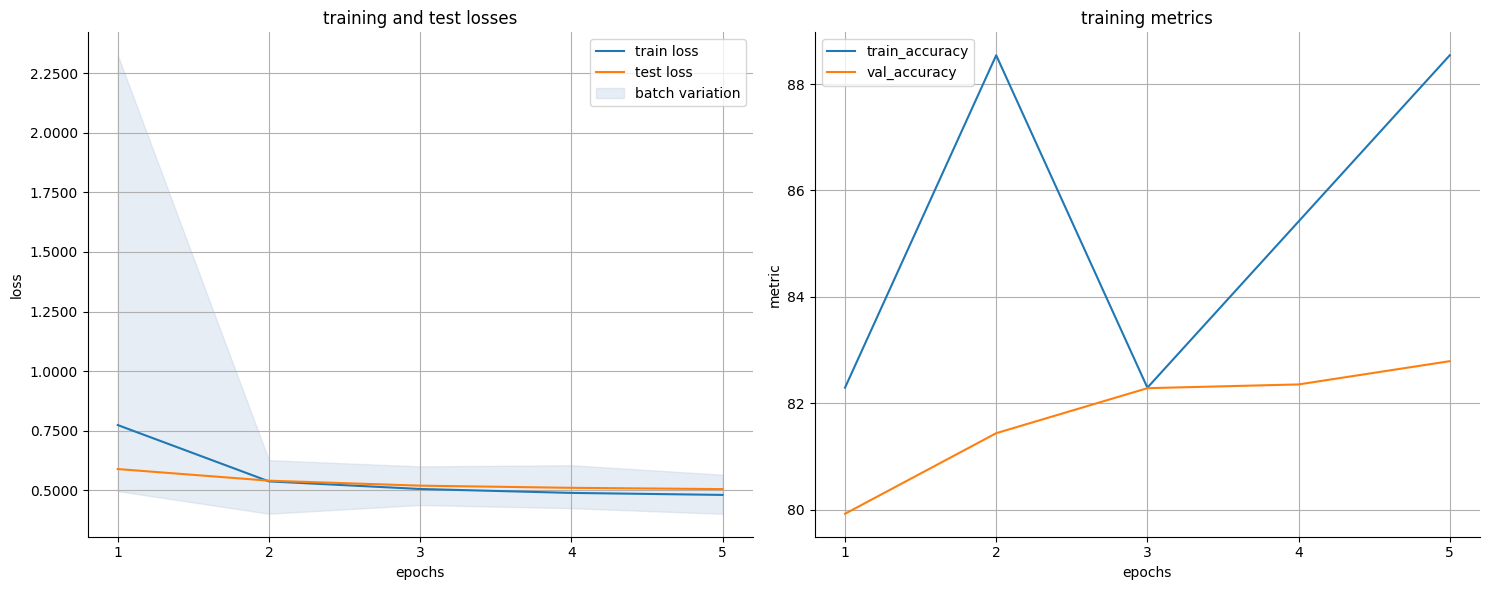

batch_loss,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▂▁▁▂▁▂▂▁▂▁▁▁▂▁▁▁▁
epoch,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████████
epoch_loss,█▂▂▁▁
metrics/accuracy,▁▅▇▇█
train/loss,█▂▂▁▁
val/loss,█▄▂▁▁
batch_loss,0.47436
epoch,5
epoch_loss,0.48009
metrics/accuracy,82.7901
train/loss,0.48009


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adadelta, Adam, SGD
from torch.optim.lr_scheduler import StepLR
import sys
from pathlib import Path

# package_root = Path('/home/goose/projects/deeplearning/deep_learning_tools')
package_root = Path('/home/gustaf/projects/deeplearning/deep_learning_tools')
sys.path.append(str(package_root))

from src import ModelTrainer
from src import accuracy, precision


# model
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        # conv layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # padding='same'
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)  # batch norm after first conv
        self.bn2 = nn.BatchNorm2d(64)  # batch norm after second conv
        self.bn3 = nn.BatchNorm2d(128)  # batch norm after third conv
        self.bn4 = nn.BatchNorm2d(256)  # batch norm after fourth conv
        # size calculation
        # 28x28 → conv1: 28x28
        # 28x28 → conv2: 28x28 → pool: 14x14
        # 14x14 → conv3: 14x14 → pool: 7x7
        # 7x7 → conv4: 7x7 → pool: 3x3
        # 3x3 → flatten: 3 * 3 * 256 = 2304
        flattened_size = 2304

        # fully connected layers
        self.flatten = nn.Flatten()
        
        # self.fc = nn.Linear(flattened_size, 32)
        self.fc = nn.Linear(input_size, output_size)  # TEST

        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_size)

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # # conv1 + batch norm + pooling
        # x = self.bn1(self.relu(self.conv1(x)))
        # # conv2 + batch norm + pooling
        # x = self.pool(self.bn2(self.relu(self.conv2(x))))
        # # conv3 + batch norm + pooling
        # x = self.pool(self.bn3(self.relu(self.conv3(x))))
        # # conv4 + batch norm + pooling
        # x = self.pool(self.bn4(self.relu(self.conv4(x))))
        # x = self.dropout1(x)

        # flatten and fully connected layer
        x = self.flatten(x)
        x = self.fc(x)  # TEST

        # x = self.fc(self.relu(x))
        # x = self.dropout2(x)
        # x = self.fc2(self.relu(x))
        # x = self.fc3(x)

        return x

# initialize model
model = Net(input_size=28*28, output_size=10)
# initialize optimizer
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)
# initialize scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.75)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=512,  # 128
    verbose=True,             # controls training progress logs
    save_metrics=False,        # controls saving of metrics visualization
    early_stopping_patience=3,
    early_stopping_delta=0.00001,
    logger_type="wandb",
    wandb_project="fashion-mnist",
    wandb_entity="futuregoose"
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=2
)

In [13]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2304, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
  (relu): ReLU(

In [6]:
from torchvision import datasets, transforms
import torch
def calculate_mean_std(dataset):
    """calculate mean and standard deviation of a dataset"""
    mean = 0.0
    std = 0.0
    total_images = len(dataset)

    for img, _ in dataset:
        mean += img.mean()
        std += img.std()

    mean /= total_images
    std /= total_images

    return mean.item(), std.item()

# normalization transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# load training and test datasets with normalization
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
valset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

# mean, std = calculate_mean_std(trainset)
# print(f'Before normalization: mean: {mean}, std: {std}')

# # normalization transform
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

# # load training and test datasets with normalization
# trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
# valset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

# mean, std = calculate_mean_std(trainset)
# print(f'After normalization: mean: {mean}, std: {std}')

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [7]:
import torch
import torch.nn as nn
from torch.optim import Adadelta, Adam, SGD
from torch.optim.lr_scheduler import StepLR
import sys
from pathlib import Path

# package_root = Path('/home/goose/projects/deeplearning/deep_learning_tools')
package_root = Path('/home/gustaf/projects/deeplearning/deep_learning_tools')
sys.path.append(str(package_root))

from src import ModelTrainer
from src import accuracy, precision


# model
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        

        # fully connected layers
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(input_size, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.99)

    def forward(self, x):
        # flatten and fully connected layer
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x

# initialize model
model = Net(input_size=28*28, output_size=10)
# initialize optimizer
optimizer = Adadelta(model.parameters(), lr=0.5, weight_decay=0.01)
# initialize scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=128,
    verbose=True,             # controls training progress logs
    save_metrics=True,        # controls saving of metrics visualization
    early_stopping_patience=3,
    early_stopping_delta=0.00001,
    logger_type="tensorboard",
    metrics=[accuracy, precision]
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=5
)

[epoch 01] train loss: 2.7873 | val loss: 1.2606 | accuracy: 68.37%, precision: 69.68%
Validation loss decreased (inf --> 1.2606). Saving model.
[epoch 02] train loss: 1.9353 | val loss: 1.2764 | accuracy: 67.80%, precision: 68.95%
EarlyStopping counter: 1 out of 3
[epoch 03] train loss: 1.8878 | val loss: 1.2910 | accuracy: 68.53%, precision: 68.98%
EarlyStopping counter: 2 out of 3
[epoch 04] train loss: 1.8489 | val loss: 1.2998 | accuracy: 68.93%, precision: 68.98%
EarlyStopping counter: 3 out of 3
🚨 Early stopping triggered.


```markdown
/home/gustaf/projects/deeplearning/deep_learning_tools/src/training/trainer.py:286: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.early_stopping.best_model_path))
```

In [6]:
len(trained_model.state_dict()['fc.weight'])

10

In [11]:
len(trained_model.state_dict()['fc.weight'][0])

784

In [5]:
trained_model.state_dict()['fc.bias']

tensor([ 0.0026, -0.1137,  0.0310, -0.0259,  0.0021, -0.0257,  0.0404, -0.0474,
         0.0364, -0.0122], device='cuda:0')

In [20]:
max(trained_model.state_dict()['fc.weight'][0])

tensor(0.0283, device='cuda:0')

In [17]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
from torchvision import datasets, transforms
import torch

def calculate_mean_std(dataset):
    """Calculate mean and standard deviation of a dataset"""
    mean = 0.0
    std = 0.0
    total_images = len(dataset)

    for img, _ in dataset:
        mean += img.mean()
        std += img.std()

    mean /= total_images
    std /= total_images

    return mean.item(), std.item()

# Data augmentation and normalization transform
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets with augmentation and normalization
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
valset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

# if you prefer to compute the mean and std from the dataset:
mean, std = calculate_mean_std(trainset)
print(f'Before normalization: mean: {mean}, std: {std}')

# updated normalization transform based on calculated mean and std
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# reload datasets with updated normalization
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
valset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

[epoch 01] train loss: 0.8352 | val loss: 0.5505 | accuracy: 79.04%
Validation loss decreased (inf --> 0.5505). Saving model.
[epoch 02] train loss: 0.5752 | val loss: 0.4629 | accuracy: 84.18%
Validation loss decreased (0.5505 --> 0.4629). Saving model.
[epoch 03] train loss: 0.5218 | val loss: 0.4283 | accuracy: 85.05%
Validation loss decreased (0.4629 --> 0.4283). Saving model.
[epoch 04] train loss: 0.4817 | val loss: 0.4077 | accuracy: 85.36%
Validation loss decreased (0.4283 --> 0.4077). Saving model.
[epoch 05] train loss: 0.4526 | val loss: 0.3589 | accuracy: 87.18%
Validation loss decreased (0.4077 --> 0.3589). Saving model.
[epoch 06] train loss: 0.4313 | val loss: 0.3553 | accuracy: 87.96%
EarlyStopping counter: 1 out of 5
[epoch 07] train loss: 0.4175 | val loss: 0.3439 | accuracy: 87.78%
Validation loss decreased (0.3589 --> 0.3439). Saving model.
[epoch 08] train loss: 0.4005 | val loss: 0.3179 | accuracy: 88.80%
Validation loss decreased (0.3439 --> 0.3179). Saving model

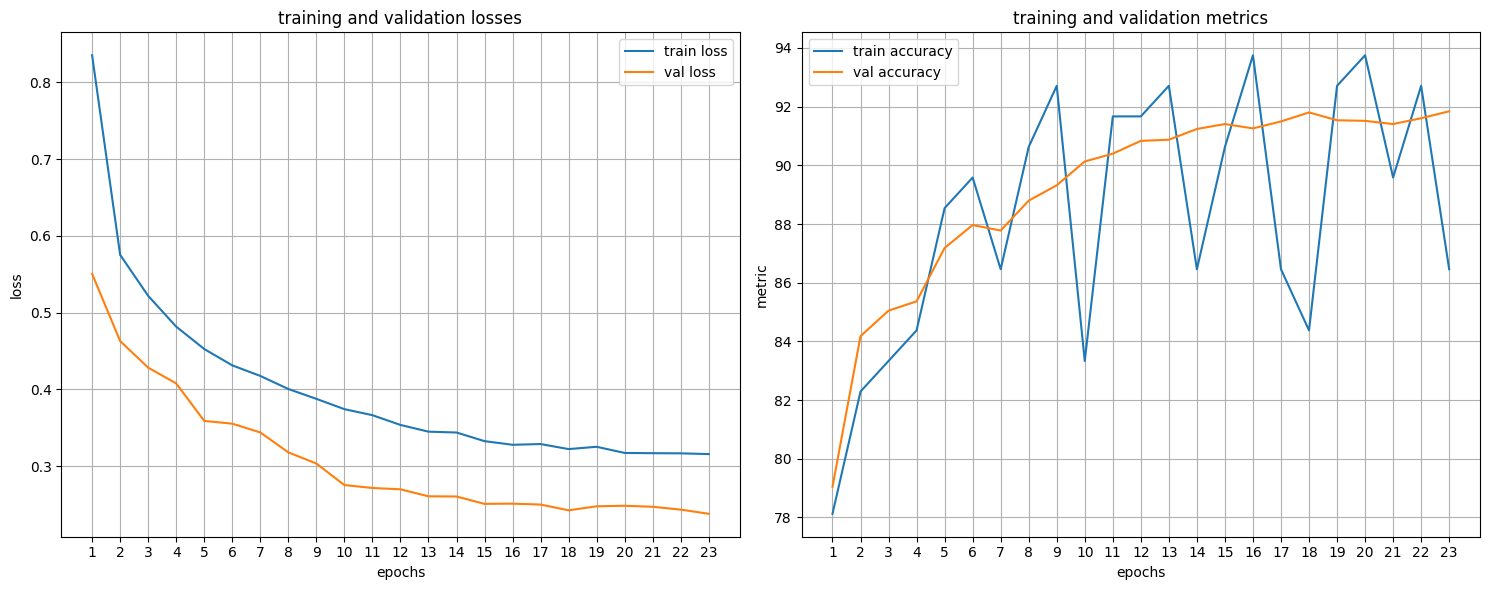

/home/gustaf/projects/deeplearning/utils/trainer.py:316: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.early_stopping.best_model_p

In [15]:
import torch
import torch.nn as nn
from torch.optim import Adadelta
from torch.optim.lr_scheduler import StepLR
import sys
from pathlib import Path


#utils_dir = Path('/home/goose/projects/deeplearning/utils')
utils_dir = Path('/home/gustaf/projects/deeplearning/utils')
sys.path.append(str(utils_dir))
from metrics import precision, recall, f1_score
from trainer import ModelTrainer


# model
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        # conv layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)  # batch norm after first conv
        self.bn2 = nn.BatchNorm2d(64)  # batch norm after second conv
        self.bn3 = nn.BatchNorm2d(128)  # batch norm after third conv
        self.bn4 = nn.BatchNorm2d(256)  # batch norm after fourth conv
        # size calculation
        # 28x28 → conv1: 28x28
        # 28x28 → conv2: 28x28 → pool: 14x14
        # 14x14 → conv3: 14x14 → pool: 7x7
        # 7x7 → conv4: 7x7 → pool: 3x3
        # 3x3 → flatten: 3 * 3 * 256 = 2304
        flattened_size = 2304

        # fully connected layers
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(flattened_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_size)

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # conv1 + batch norm + pooling
        x = self.bn1(self.relu(self.conv1(x)))
        # conv2 + batch norm + pooling
        x = self.pool(self.bn2(self.relu(self.conv2(x))))
        # conv3 + batch norm + pooling
        x = self.pool(self.bn3(self.relu(self.conv3(x))))
        # conv4 + batch norm + pooling
        x = self.pool(self.bn4(self.relu(self.conv4(x))))
        x = self.dropout1(x)

        # flatten and fully connected layer
        x = self.flatten(x)
        x = self.fc(self.relu(x))
        x = self.dropout2(x)
        x = self.fc2(self.relu(x))
        x = self.fc3(x)

        return x

# initialize model
model = Net(input_size=28*28, output_size=10)
# initialize optimizer
optimizer = Adadelta(model.parameters(), lr=0.5, weight_decay=0.01)
# initialize scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=128,
    verbose=True,             # controls training progress logs
    verbose_details=True,     # controls hyperparameters and model summary logs
    enable_logging=True,      # controls overall logging
    save_metrics=True,        # controls saving of metrics visualization
    early_stopping_patience=5,
    early_stopping_delta=0.005,
    metrics=[ModelTrainer.accuracy]
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=100
)

Before normalization: mean: -0.4443073868751526, std: 0.6403351426124573
Using device: cuda


In [22]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

[Epoch 01] Train Loss: 0.5536 | Val Loss: 0.4885 | accuracy: 82.74%
Validation loss decreased (inf --> 0.4885). Saving model.
[Epoch 02] Train Loss: 0.3883 | Val Loss: 0.3603 | accuracy: 87.10%
Validation loss decreased (0.4885 --> 0.3603). Saving model.
[Epoch 03] Train Loss: 0.3480 | Val Loss: 0.3309 | accuracy: 88.64%
Validation loss decreased (0.3603 --> 0.3309). Saving model.
[Epoch 04] Train Loss: 0.3232 | Val Loss: 0.2844 | accuracy: 89.93%
Validation loss decreased (0.3309 --> 0.2844). Saving model.
[Epoch 05] Train Loss: 0.2998 | Val Loss: 0.2813 | accuracy: 90.03%
Validation loss decreased (0.2844 --> 0.2813). Saving model.
[Epoch 06] Train Loss: 0.2811 | Val Loss: 0.2682 | accuracy: 90.62%
Validation loss decreased (0.2813 --> 0.2682). Saving model.
[Epoch 07] Train Loss: 0.2685 | Val Loss: 0.2374 | accuracy: 91.60%
Validation loss decreased (0.2682 --> 0.2374). Saving model.
[Epoch 08] Train Loss: 0.2505 | Val Loss: 0.2396 | accuracy: 91.74%
EarlyStopping counter: 1 out of 5
[Epoch 09] Train Loss: 0.2390 | Val Loss: 0.2382 | accuracy: 91.59%
EarlyStopping counter: 2 out of 5
[Epoch 10] Train Loss: 0.2270 | Val Loss: 0.2237 | accuracy: 92.24%
Validation loss decreased (0.2374 --> 0.2237). Saving model.
[Epoch 11] Train Loss: 0.2170 | Val Loss: 0.2178 | accuracy: 92.35%
Validation loss decreased (0.2237 --> 0.2178). Saving model.
[Epoch 12] Train Loss: 0.2095 | Val Loss: 0.2234 | accuracy: 92.25%
EarlyStopping counter: 1 out of 5
[Epoch 13] Train Loss: 0.2037 | Val Loss: 0.2138 | accuracy: 92.51%
Validation loss decreased (0.2178 --> 0.2138). Saving model.
[Epoch 14] Train Loss: 0.1934 | Val Loss: 0.2156 | accuracy: 92.52%
EarlyStopping counter: 1 out of 5
[Epoch 15] Train Loss: 0.1919 | Val Loss: 0.2135 | accuracy: 92.59%
EarlyStopping counter: 2 out of 5
[Epoch 16] Train Loss: 0.1866 | Val Loss: 0.2104 | accuracy: 92.84%
Validation loss decreased (0.2138 --> 0.2104). Saving model.
[Epoch 17] Train Loss: 0.1846 | Val Loss: 0.2105 | accuracy: 92.84%
EarlyStopping counter: 1 out of 5
[Epoch 18] Train Loss: 0.1803 | Val Loss: 0.2096 | accuracy: 92.83%
EarlyStopping counter: 2 out of 5
[Epoch 19] Train Loss: 0.1761 | Val Loss: 0.2101 | accuracy: 92.67%
EarlyStopping counter: 3 out of 5
[Epoch 20] Train Loss: 0.1737 | Val Loss: 0.2104 | accuracy: 92.74%
EarlyStopping counter: 4 out of 5

In [3]:
import sys
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/gustaf/projects/deeplearning/venv/lib/python3.10/site-packages',
 '/tmp/tmpib4pb75e',
 '/home/gustaf/projects/deeplearning/utils']

In [4]:
print(type(1e-3))

<class 'float'>


In [5]:
print(type(0.001))

<class 'float'>
